This notebooks illustrates a pipeline for extracting overrepresented k-mers in set of sequences also called peaks.<br/>
Peaks are supposed to be produced by ChIP-seq experiments and they are examined in order to extract transcription factor binding sites (TFBS).<br/>
In the current form, the pipeline contains an initial procedure to extract variable-length words that are present in at least a given percentage of peaks. <br/>
The extracted words are then scored by means of different scoring procedures that are also compared each other.

# General notation

We denote with $S$ the input set of **peaks**, that are strings in the genomic **alphabet** $\Gamma = \{A,C,G,T\}$ .<br>
$S_i$ is th $i$-th peak, and they are ordered by their position in the reference genome.

We denote with $D(S)$ the complete set of substrings in $S$, of any length.<br>
Moreover, we denote with $D_K(S)$ the complete set of $k$-mers (words of a specific length $k$) that appeat at least once in $S$.

Given a word $w$ and a set of strings $S$, the **document listing problem** consists in enumerating the strings were $w$ occurrs at least once.<br>
We define $dl(w,S)$ the document listing of $w$ in $S$, also called the **support** of $w$ in $W$, namely the list of strings of $S$ where $w$ occurrs.<br>

We denote with $ml(w,S)$ the total number of occurrences of $w$ in S, and with $ml(w,S_i)$ the number of occurrences of $w$ within the specific string $S_i$.

----

# A data structure to bring them all
In what follows, an enhaced suffix array (**ESA**) is used as main data structure on top of which algorithms are built.<br>
Wew remind that the ESA data structure is composed of the suffix arry $SA$ and the longest common prefix array $LCP$.<br>
Teh ESA structure is built for the set of sequences $S$, thus it represents all the suffixes of the strings in $S$.<br>
Teh structure is built on the concatenation of the strings in $S$ that is in the form $\mathbb{S} = S_1\$S_2\$\dots S_i\$S_{i+1}\$\dots \$S_n\$$.<br>

The followiing source code describes as a set of input sequences in FASTA format are read and concatenated into a global string.

In [1]:
def read_global_sequence(ifile, first_n=None):
    """
    Read a set of sequences in FASTA format and concatenat them into a global squences.
    Returns:
        - the original list of strings
        - a dict which maps sequence names (defined by the comment rows in the FASTA file) to their ID (defined by the order in which they are readed, starting from 0)
        - the global sequence ibtained by concatenation
    """
    gs = ''
    iline = 0
    seqname = ''
    seqname2id = dict()
    ipeaks = list()
    for line in open(ifile, 'r'):
        if iline%2 == 0:
            seqname = line.strip()
            seqname2id[seqname] = iline/2
        else:
            s = line.strip().upper().replace('N','$') + '$'
            ipeaks.append( (s, seqname) )
            gs += s
        iline += 1
        if first_n!=None and iline/2==first_n:
            break
    return ipeaks, seqname2id, gs 

The ESA structure is enriched with two additional arrays:
<ul>
    <li>the <b>DL array</b>  which reports for each suffix the string in $S$ to which it belongs to</li>
    <li>the <b>NN array</b> that is used in case the input string contains ambiguous characters $N$. This array is used in order to discard k-mer which contains $N$ characters in an efficient way</li>
</ul>

The following source code defined the given data structure, also called **DNESA**, and an iterator that can be used for enumerating all the $k$-mers contained in it.

In [2]:
class DNESA:
    def __init__(self, _sa, _lcp, _nn, _dl, _gs):
        self.sa = _sa
        self.lcp = _lcp
        self.nn = _nn
        self.dl = _dl
        self.gs  = _gs
        
    def search(self, w):
        l = 0
        r = len(self.gs)-1
        #ll,lr,rl,rr,m,cq
        for i in range(len(w)):
            #print('i',i)
            
            """
            while (l<len(self.nn)) and (self.nn[l] < len(w)-i):
                l += 1
            if l>r or (self.gs[self.sa[l]+i] > w[i]):
                return None,None
            
            while (r>l) and ( self.nn[r]<len(w)-i ):
                r -= 1
            if r<l or (self.gs[ self.sa[r]+i]<w[i] ):
                return None,None
            
            #print('new lr',l,r)
            """
            
            ll = l
            lr = r
            while ll!=lr:
                m = ll + int( (lr-ll)/2 )
                if w[i] <= self.gs[self.sa[m]+i]:
                    lr = m
                else:
                    ll = m+1
            l = ll
            #print('l',l)
            if l>r or w[i]!=self.gs[self.sa[l]+i]:
                return None,None
            
            #print('new l',l)
            
            rl = l
            rr = r
            #print(rl,rr)
            while rl!=rr:
                m = rl + int( (rr-rl)/2 )
                #print(rl,rr,m)
                if (rr-rl)%2 != 0:
                    m += 1
                if w[i] < self.gs[self.sa[m]+i ]:
                    rr = m-1
                else:
                    rl = m
            r = rr
            if r>len(self.sa) or self.gs[self.sa[r]+i] !=w[i]:
                return None,None
        
        return l,r+1



class NESAIterator:
    __s = None
    __k = 0
    __sa = None
    __lcp = None
    __ns = None
    __i = 0
    __j = 0
    
    def __init__(self, s, k, sa , lcp, ns):
        self.__s = s
        self.__k = k
        self.__sa = sa
        self.__lcp = lcp
        self.__ns = ns

    def get_k(self):
        return self.__k
    
    def reset(self):
        self.__i = 0
        self.__j = 0
        
        
    def __iter__(self):
        return self
    def __next__(self):
        if self.__i < len(self.__s):
            self.__i = self.__j
            
            while (self.__i < len(self.__s)) and  ( (self.__sa[self.__i] > len(self.__s) - self.__k - 1) or (self.__ns[self.__i] < self.__k) ):
                self.__i += 1
            if self.__i == len(self.__s):
                raise StopIteration
            self.__j = self.__i+1
            while ( self.__j < len(self.__s) ) and (self.__lcp[self.__j] >= self.__k) and (self.__ns[self.__i] >= self.__k) :
                self.__j += 1
            ret = self.__s[ self.__sa[self.__i] : self.__sa[self.__i] + self.__k ]
            #self.__i = self.__j #!!!!!!
            return ret
        else:
            raise StopIteration
            
    def get_start(self):
        return self.__i
    
    def get_end(self):
        return self.__j
    
    def multiplicity(self):
        return self.__j - self.__i
    
    def positions(self):
        return self.__sa[self.__i : self.__j]

The following source code provides a procedure to build the DNESA structure starting from an input set of sequences in FASTA format.<br>
The structure is write into a CSV file. 

In [3]:
import pandas
def build_DNESA(i_sequences_file, o_dataframe_file, first_n=None):
    ifile = i_sequences_file
    print('reading sequences')
    iline = 0
    seqname = ''
    seqname2id = dict()
    ipeaks = list()
    for line in open(ifile, 'r'):
        if iline%2 == 0:
            seqname = line.strip()
            seqname2id[seqname] = iline/2
        else:
            ipeaks.append( (line.strip().upper().replace('N','$') + '$', seqname) )
        iline += 1
        if first_n!=None and iline/2==first_n:
            break
            
    print('making global sequence')
    global_sequence = ''
    suffixes = list()
    for i in range(len(ipeaks)):
        peak = ipeaks[i][0]
        seqname = ipeaks[i][1]

        for p in range(len(peak)):
            suffixes.append( (len(global_sequence) + p, i) )
        global_sequence += peak

    print('seqname2id', len(seqname2id))
    print('global_sequence', len(global_sequence))
    print('suffixes', len(suffixes))
    
    print('ordering suffixes')
    def compare_suffixes(t1, t2):
        #print('comparing',t1,t2)
        i = t1[0]
        j = t2[0]
        l = len(global_sequence)
        k = 0
        while (i+k<l and j+k<l and global_sequence[i+k]==global_sequence[j+k]):
            k += 1
        if i+k==l:
            return -1
        elif j+k==l:
            return 1
        else:
            #print('@', ord(global_sequence[i+k]) - ord(global_sequence[j+k]))
            return ord(global_sequence[i+k]) - ord(global_sequence[j+k])

    from functools import cmp_to_key
    suffixes = sorted(suffixes, key=cmp_to_key(compare_suffixes) )

    sa = [ i[0] for i in suffixes]
    dl = [ i[1] for i in suffixes]

    for i in range(10):
        print(suffixes[i], global_sequence[suffixes[i][0]: suffixes[i][0]+30 ])
      
    print('creating LCP array')
    
   
    length = len(global_sequence)
    rank = [0 for i in range(length)]
    for i in range(length):
        rank[ sa[i] ] = i
    lcp = [0 for i in range(length)]
    h = 0
    for i in range(length):
        k = rank[i]
        if k==0:
            lcp[k] = -1
        else:
            j = sa[k-1]
            while (i+h<length) and (j+h<length) and (global_sequence[i+h] == global_sequence[j+h] ):
                h += 1
            lcp[k] = h
        if h>0:
            h -= 1
    
    print('creating NN array')
    length = len(sa)
    nn = [0 for i in range(length)]
    pn = length
    for i in range(length-1, -1, -1):
        if global_sequence[i]=='N' or global_sequence[i]=='$':
            nn[i] = 0
            pn = i
        else:
            nn[i] = pn -i
    fn = [0 for i in range(length)]
    for i in range(length):
        fn[i] = nn[sa[i]]
    nn = fn
    
    i = 0
    while global_sequence[sa[i]] == '$':
        i += 1

    #for i in range(i, i+10):
    #    print(global_sequence[suffixes[i][0]: suffixes[i][0]+30 ], global_sequence[sa[i]: sa[i]+30 ], sa[i], lcp[i], nn[i], dl[i])
        
    print('saving  dataframe to csv', o_dataframe_file)
    import pandas
    df = pandas.DataFrame()
    df['sa'] = sa
    df['lcp'] = lcp
    df['nn'] = nn
    df['dl'] = dl
    df.to_csv(o_dataframe_file)

This is an example of how to build a DNESA structure, save it and finally reload it into memory.<br>
Pandas DataFrame columns are converted into lists in order to increase the efficiency when using them.

In [4]:
# building and writing
build_DNESA('ENCFF682EOV_allseqs.fa', 'ENCFF682EOV_allseqs.nelsa.csv')

# reading
epeaks, es2n, egs = read_global_sequence('ENCFF682EOV_allseqs.fa')
edf = pandas.read_csv('ENCFF682EOV_allseqs.nelsa.csv')
print(len(epeaks), len(es2n), len(egs))
e_dnesa = DNESA(list(edf.sa), list(edf.lcp), list(edf.nn), list(edf.dl), egs)

reading sequences
making global sequence
seqname2id 39175
global_sequence 18034838
suffixes 18034838
ordering suffixes
(18034837, 39174) $
(10306314, 18840) $$$GATCCTTGAAGCGCCCCCAAGGGCATC
(10306315, 18841) $$GATCCTTGAAGCGCCCCCAAGGGCATCT
(16449106, 33800) $AAAAAAAAAAAAAAAAAAAAAAAAACCAA
(843959, 1289) $AAAAAAAAAAAAAAAAAAAAAAAAATATA
(7453297, 13158) $AAAAAAAAAAAAAAAAAAAAAAAAGAGGC
(11484350, 21316) $AAAAAAAAAAAAAAAAAAAAAAGAAAAAG
(9507287, 17205) $AAAAAAAAAAAAAAAAAAAAGGAAATGTC
(10262388, 18749) $AAAAAAAAAAAAAAAAAAGACTGCGCCAT
(11531378, 21418) $AAAAAAAAAAAAAAAAAAGGTAAAAAAAA
creating LCP array
creating NN array
saving  dataframe to csv ENCFF682EOV_allseqs.nelsa.csv
39175 39175 18034838


----

# Plotting procedure
This section simply report the plotting procedure used to make scatter plots of out data.

In [5]:
import matplotlib.pyplot as plt
def plot_2d_scatter(df, col1, col2, plotsize=(5,5), up_hist_logscale=False):
    import matplotlib.pyplot as plt

    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.001
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]

    x = df[col1]
    y = df[col2]

    plt.figure(figsize=plotsize)
    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True)
    plt.xlabel(col1)
    plt.ylabel(col2)
    ax_histx = plt.axes(rect_histx)
    ax_histx.tick_params(direction='in', labelbottom=False)
    if up_hist_logscale:
        ax_histx.set_yscale('log')
    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=False, labelbottom=False, labeltop=False)

    ax_scatter.scatter(x, y, marker='x')
    ax_histx.margins(x=0,y=0.1, tight=True)
    ax_histx.hist(x, bins=20)
    #ax_histx.margins(0)
    ax_histx.margins(x=0,y=0.1, tight=True)
    ax_histy.hist(y, orientation='horizontal', bins=20)
    ax_histy.margins(x=0.1,y=0, tight=True)
    #ax_histy.set_xticks([])
    plt.show()

----

# k-mer score over PWM matrices (score and norm_score)

This section describes a procedure to calculate a score for a given k-mer over a PWM matrix of length $l$, when $ k \leq l$.<br>
Given an alphabet $\Sigma = \{ A,C,G,T \}$, a Position weight matrix (PWM) $M$ of length $|M|$ is a function $ f : \Sigma \times |M| \mapsto \mathbb{N} $.<br>
Thus, if we think about the PWM as a matrix where rows are indexed by symbols in $\Sigma$, each column represent a given position of the bindsing site.<br>
Moreover, $M$ is built such that the sum over columns are ensured to be equalt. Thus, for every $1 \leq i \leq |M|$, $\sum_{a \in \Sigma} M[a][i] = x$, for a given value of $x$.

Given a $k$-mer $w$ having the same length of $M$, the score of $w$ is given by $s(w,M) = \sum_{1 \leq i \leq |M|}M[ w[i] ][i]$, being $w[i]$ the $i$-th character of $w$.<br>
This score can be normalized by taking into account the maximum possbile score that can be obtained in the PWM.

If the length of the k-mer is less than the length of the PWM, then we are interested in finding the position $i$ where a maximum score for the k-mer can be obtained.<br>
Thus, we want to find the position $i$ which maximizes the score $s(w,M,i) = \sum_{i \leq j \leq i+|w|}M[ w[j-i] ][i]$, for $1 \leq i \leq |M| - |w|$.<br>
Therefore, for a k-mer $w$, such that $|w|\leq|M|$, $s(w,M) = max_{s(w,M,i)}\{ $ for $ 1 \leq i \leq |M| - |w| \}$.<br>
Moreover, this score can be normalized by taking into account the maximum score that can be obtained in the PWM by scanning for a unspecified word of length $|w|$, that is $ max_{s(t,M,i)}\{$ for $ t \in \Sigma^{|w|} $, for $ 1 \leq i \leq |M| - |w| \}$.


In [6]:
import re
def read_jaspar(ifile):
    """
    read a PWM matrix in jaspar format
    """
    motif = dict()
    for line in open(ifile,'r'):
        if line[0]!='>':
            line = line.strip()
            c = line[:line.index('[')].strip()
            motif[c] = list()
            s = re.split('\s+', line.strip())
            for i in range(2, len(s)-1):
                motif[c].append( int(s[i]) )
    return motif

def get_full_motif_score(pwm, word):
    """
    get the unnormalized score over a PWM matrix M for a word w wuch that |M| = |w|
    """
    score = 0.0
    for i in range(len(word)):
        score += pwm[word[i]][i]
    return score

def get_normalized_motif_score(m, w):
    """
    get the uormalized score over a PWM matrix M for a word w wuch that |M| >= |w|
    """
    lm = len(m[next(iter(m.keys()))])
    max_score = 0.0
    w_score = 0.0
    t =  [ max( [ m[k][i] for k in m.keys() ] ) for i in range(lm) ] 
    for i in range(lm-len(w)+1):
        ms = sum( t[i:i+len(w)] )
        if ms > max_score:
            max_score = ms
        ws = 0.0
        for j in range(len(w)):
            ws += m[w[j]][i+j]
        if w_score < ws:
            w_score = ws
    return w_score/max_score, w_score, max_score


# Some statistics regarding an already known PWM of CTCF

In what follows we try to understand how the k-mers generated via an already built PWM for the binding sites of CTCF match in a given set of sequences.<br>
In particular, we study the diffusion (suppport) of k-mers within the set of sequences in relation to the score that each k-mer gets in the PWM. 

In [7]:
import pandas

epeaks, es2n, egs = read_global_sequence('ENCFF682EOV_allseqs.fa')
edf = pandas.read_csv('ENCFF682EOV_allseqs.nelsa.csv')
print(len(epeaks), len(es2n), len(egs))
e_dnesa = DNESA(list(edf.sa), list(edf.lcp), list(edf.nn), list(edf.dl), egs)

ctcf = read_jaspar('MA0139.1.jaspar')

39175 39175 18034838


In [8]:
import pandas

k = len(ctcf['A'])
print('k',k)
it = NESAIterator( egs, k, list(edf.sa) , list(edf.lcp), list(edf.nn))
dl = list(edf.dl)

words = list()
scores = list()
dls = list()
mults = list()

for kmer in it:
    #print(kmer, it.multiplicity(), it.positions())
    #print(it.multiplicity(), it.positions())
    #print(kmer, it.multiplicity())
    words.append(kmer)
    mults.append( it.multiplicity())
    scores.append( get_full_motif_score(ctcf, kmer)  )
    dls.append( len(  set(  dl[ it.get_start() : it.get_end() ]  ) ) )
    
epwmstats = pandas.DataFrame()
epwmstats['word'] = words
epwmstats['score'] = scores
epwmstats['dl'] = dls
epwmstats['mult'] = mults
epwmstats.sort_values('score', ascending=False, inplace=True)


display(epwmstats)
print('max dl value', max(epwmstats['dl']))

k 19


,word,score,dl,mult
15051062,TGGCCACCAGGGGGCGCCG,11529.0,1,1
15051063,TGGCCACCAGGGGGCGCTC,11518.0,1,1
15050942,TGGCCACCAGAGGGCGCTA,11506.0,1,1
6996524,CGGCCACCAGGGGGCGCCA,11497.0,1,1
15051064,TGGCCACCAGGGGGCGGCA,11490.0,1,1
...,...,...,...,...
3726228,ATCTGCTGCTCCCAGCTGT,703.0,1,1
10039876,GCCTTCAGCCTCCTGTTGT,703.0,1,1
10012174,GCCTGCAGCTCCTTGCTGT,702.0,1,1
10044259,GCCTTCTGGCTCCCTCTGT,690.0,1,1


max dl value 376


In [9]:
epwmstats.to_csv('kmers-stats_ENCFF682EOV_allseqs.csv')

KeyboardInterrupt: 

In [10]:
import statistics
print(statistics.mean(epwmstats[ epwmstats.dl > 1]['dl']))

print(epwmstats.groupby('dl').size())

print(epwmstats.groupby(['dl']).agg(['mean']))

print(max(epwmstats.dl), len(set(edf.dl)))

3.642135296705572
dl
1      16697977
2        104523
3         21876
4          9102
5          4917
         ...   
321           1
327           1
328           1
334           1
376           1
Length: 192, dtype: int64
           score         mult
            mean         mean
dl                           
1    4305.469613     1.000788
2    4352.289266     2.009414
3    4344.372966     3.013714
4    4334.299385     4.021094
5    4356.056132     5.048403
..           ...          ...
321  4512.000000   322.000000
327  3825.000000   330.000000
328  5031.000000   330.000000
334  3878.000000  2002.000000
376  2270.000000  2251.000000

[192 rows x 2 columns]
376 39175


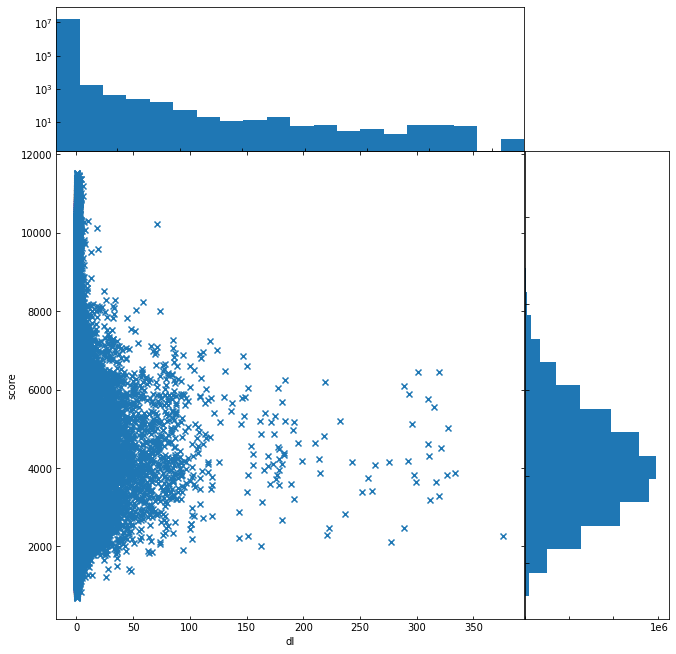

In [11]:
plot_2d_scatter(epwmstats, 'dl', 'score', plotsize=(10,10), up_hist_logscale=True)

k 4


,word,score,dl,mult
81,CCAC,1.000000,33558,95646
166,GGCG,0.976471,19010,59985
169,GGGC,0.975462,30765,107086
148,GCCA,0.973445,33942,95061
170,GGGG,0.962353,28672,114055
...,...,...,...,...
195,TAAT,0.399664,26418,66296
207,TATT,0.398992,27806,81497
247,TTCT,0.391261,34660,116181
223,TCTT,0.349916,32934,97552


max dl value 35819


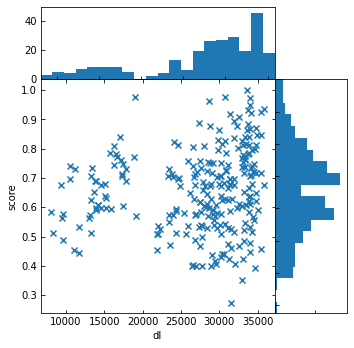

In [12]:
import pandas

k = 4
print('k',k)
it = NESAIterator( egs, k, list(edf.sa) , list(edf.lcp), list(edf.nn))
dl = list(edf.dl)

words = list()
scores = list()
dls = list()
mults = list()

for kmer in it:
    #print(kmer, it.multiplicity(), it.positions())
    #print(it.multiplicity(), it.positions())
    #print(kmer, it.multiplicity())
    words.append(kmer)
    mults.append( it.multiplicity())
    scores.append( get_normalized_motif_score(ctcf, kmer)[0]  )
    dls.append( len(  set(  dl[ it.get_start() : it.get_end() ]  ) ) )
    
epwmstats = pandas.DataFrame()
epwmstats['word'] = words
epwmstats['score'] = scores
epwmstats['dl'] = dls
epwmstats['mult'] = mults
epwmstats.sort_values('score', ascending=False, inplace=True)


display(epwmstats)
print('max dl value', max(epwmstats['dl']))

plot_2d_scatter(epwmstats, 'dl', 'score')

----

# Two background models

In order to assign a score to a k-mer that has been extracted by a given procedure, we can take into account the divergenge from the real case to a *random* one, also called background model.<br>
Here two different background models.

## Nucleotide shuffling procedure
The first one is computed by randomly shuffling the nucleotides in each sequence $S_i$, up to a given percentage. This model ensures that the 1-mer content of input sequences are preserved, however it may disrupt the k-mer composition for $k>2$. In fact, it is possible that, if sequences $S_i$ belong to a genome $G$, that this procedure may produce k-mers that do not belong to $G$. On the contrary, a pro of this method is that it try to preserve the context form which the sequences has been extracted.

In [13]:
import math
import random

random.seed(0)

iseqs = 'ENCFF682EOV_allseqs.fa'
oseqs = 'ENCFF682EOV_allseqs_shuff.fa'

shuff_perc = 0.2

def shuffle_seq(s):
    s = [ c for c in s.upper()]
    positions = [ i for i in range(len(s)-1) if s[i]!='N' ]
    for n in range( math.ceil(len(positions)*shuff_perc) ):
        i = random.randrange(0, len(positions) )
        j = random.randrange(0, len(positions) )
        t = s[i]
        s[i] = s[j]
        s[j] = t
    return ''.join(s)

with open(oseqs,'w') as off:
    iline = 0
    for line in open(iseqs,'r'):
        if iline%2==0:
            off.write(line)
        else:
            s = shuffle_seq(line)
            off.write(s)
            if iline < 20:
                print(line[:100], s[:100])
        iline +=1
    
print(iline)

TGCTCCATGTTTATTCCGTTCAGTCAGAAAAGAAATATCCAATTAGGACTTCTTTCTTAGTCTCCCTCCTCTCTCCCACCACCTTCTCCTTAAGGGATTG TGCTCCATGTTTCGGCAGTTCAGCCAGTAAAGGTATAACATGTTAGTCCTTCTTTCTTAATCAATCTCCTACCTCGCACCTCCTGCTCCTTCACGTATTG
tgaacagtctctgtttgggcgtctagatccctttgagaatctgtcgaaagctcattcacagaagaaaaactcacacaaacaaaggttgcaggcaatttcC TGTACAGTCGCTGTTGGGGTCTCTAGATGCCTTTCATACCGACGCGAAAGCCCATTAACAGATTACAGACTCGCACAACCAAAAGCAGCAGGAAACTTCC
ttggcctcccaaagttctgggattacaggcatgagccaccgtgcccgaccATCTTCCAAAACTGAGCTGTGATGTCCTTCCTCTAGAACACCTGACCACA TTGCCCTCACAAAGTTCTGGGTATAGACTCATGTGCTACGGTGCCTGATCATCTTCCAAGATTGGGCTGTGAGGCCCCTTTTTAAGCATACCTCGCCACA
aatgcgaggacagactaatacaATCTTCTACTCCCAGATCCCCGCACACGCTTAGCCCCAGACATCACTGCCCCTGGGAGCATGCACAGCGCAGCCTCCT AACGCGACGACAGGTTAACCCAATCCTCTATTCGGAGATCCCAGCACACGGACGGTCCCAGACATCACGGTGGCCGGGGGCACGTTCAGTTCTGCCTTCT
ggaaccagccgaccagctgagcggagaaaaaaggctctgtggacacatttgttgacataaccaaaggtcatattcgttACCCTGGACTTCATGcagactc GGCACCCGCCGTCAAGCTGCGCGCGGAAGACTGTGTCGGTGGGCTTAGTTGTAGACATTACTAGAACTCATATTCGTTACCAGACACTTCA

In [ ]:
build_DNESA('ENCFF682EOV_allseqs_shuff.fa', 'ENCFF682EOV_allseqs_shuff.nelsa.csv')

## Sequence re-extraction procedure 
A second procedure randomly extracts sequences from a genome $G$ by preserving the length of the sequences extracted in position $i$. In this way, the new sequences are originated formt he genome $G$, thus it is ensured that every k-mers occuring in them is a *real* k-mer. On the contrary, no restriction is ensured regarding the context from which they are extracted.

This procedure is made by using the bed tools software.

In [24]:
build_DNESA('ENCFF682EOV_allseqs_random.fa', 'ENCFF682EOV_allseqs_random.nelsa.csv')

reading sequences
making global sequence
seqname2id 39175
global_sequence 18034838
suffixes 18034838
ordering suffixes
(18034837, 39174) $
(7317948, 12900) $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
(7317949, 12901) $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
(7317950, 12901) $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
(7317951, 12901) $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
(7317952, 12901) $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
(7317953, 12901) $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
(7317954, 12901) $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
(7317955, 12901) $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
(7317956, 12901) $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
creating LCP array
creating NN array
saving  dataframe to csv ENCFF682EOV_allseqs_random.nelsa.csv


----

# A ranking procedure for k-mers based on KL divergence terms (kl_rank and norm_kl_rank)

This section shows a methodology to rank k-mers, being all of the same length $k$, by taking into account their single contribution to the calculation of a Kullback-Leibler (KL) divergence form a real case, also called foreground, and a background model $B$.<br>
Given a word length $k$, the procedure takes into account the multiplicities of the k-mers occurring at least one in the foreground sequence set $S$.<br>
The KL divergence is calculated as $ \sum_{w \in D_k(S)}p(w,S) log \frac{p(w,S)}{p(w,B)} $, where p(w,S) is the frequency of $w$ in $S$, that is computed as $\frac{ml(w,S)}{ \sum_i{|S_i|-|w|+1}}$ if sequences in $S$ do not contains $N$ characters.<br>
For practical applicatios, it is possible that a k-mer does not occurr in the backgorund set $B$, in this case a very small value is assigned to it and it is ensured that $\sum_{w \in D_k(S)}p(w,B) = 1$.<br>
Givne a k-mer, its rank is caluclated by ordering the k-mers by their values such that  $kl\_rank(w,S,B) = p(w,S) log \frac{p(w,S)}{p(w,B)}$. In this way a k-mer that is over-represented in the foregound w.r.t the background set has a positive contribution, and k-mers that are under-represented have negative contributions.

In addition, the $kl\_rank$ values can be normalized to be values in $[0,1]$ by taking into account the minimum value $kl_min = min_{w \in D_k(S)} kl\_rank(w,S,B)$ and the maximum value $kl_max = max_{w \in D_k(S)} kl\_rank(w,S,B)$, such that $norm\_kl\_rank(w,S,B) = \frac{kl\_rank(w,S,B)  - kl\_min}{kl\_max - kl\_min} $

In [25]:
import math

def get_kl_scores(k, egs, edf, rgs, rdf):
    f_kmers = dict()

    it =  NESAIterator( egs, k, list(edf.sa) , list(edf.lcp), list(edf.nn))
    for kmer in it:
        f_kmers[kmer] = it.multiplicity()

    b_kmers = dict()

    it =  NESAIterator( rgs, k, list(rdf.sa) , list(rdf.lcp), list(rdf.nn))
    for kmer in it:
        b_kmers[kmer] = it.multiplicity()

    kmers = f_kmers.keys() | b_kmers.keys()

    for kmer in kmers:
        f_kmers[kmer] = f_kmers.get(kmer,0)+1
        b_kmers[kmer] = b_kmers.get(kmer,0)+1

    f_sum = sum(f_kmers.values())
    b_sum = sum(b_kmers.values())

    scores = dict()
    sorted_scores = list()
    for kmer in kmers:
        f_kmers[kmer] = f_kmers[kmer]/f_sum
        b_kmers[kmer] = b_kmers[kmer]/b_sum
        scores[kmer] = f_kmers[kmer] * math.log( f_kmers[kmer] / b_kmers[kmer] )
        sorted_scores.append((scores[kmer],kmer))
    sorted_scores = sorted(sorted_scores, reverse=True)
    
    min_score = min(scores.values())
    max_score = max(scores.values())
    
    norm_sorted_scores = list()
    for s in sorted_scores:
        norm_sorted_scores.append(  (  (s[0]-min_score)/(max_score - min_score), s[1] )  )
        
    return sorted_scores, norm_sorted_scores
    

----

# A DL-aware scoring procedure for k-mers of variable length (norm_kl_score)
This section shows a scoring procedure that can be used ot recognize statistically over-represented k-mers in a set of sequence, such that the computation of the score for a specific k-mer does not depend form the computaiton of the score of any other k-mer.<br>
In addiction, this procedure enables to take into account the contribution that each sequence in the input set $S$ has to the multiplicity of the k-mer.<br>
The only constraint is that $|S_i| = |B_i|$.<br>
Given a k-mer $w \in D_k(G)$, the score of $w$ is calculated by normalizing the divergence $KL(w,S,B) = \sum_i{ p(w,S_i) log \frac{p(w,S_i)}{p(w,B_i)} }$ for the maximum value of KL that the distribution $p(w,S_i)$ can reach.<br>
In order to estimate the maximum KL value for the distribution $p(w,S_i)$, we takes into account a reordering of the sequences $S_i$, referred to as $\widehat{S}$, such that $p(w,\widehat{S_i})\geq p(w,\widehat{S_{i+1}})$, and a reodering $\bar{S}$ such that $p(w,\bar{S_i})\leq p(w,\bar{S_{i+1}})$.<br>
It can be shown that the given score is not the maximum that the KL divergence can reach, when $p(w,S_i), p(w,B_i) \neq 0$, however, we can empirically show that it is a good upperbound to the KL value in practical applications.<br>
Finally, the score for a given k-mer $w$ is $norm\_kl\_score(w,S,B) = \frac{KL(w,S,B)}{KL(w,\widehat{S},\bar{S})}$.

In [15]:
def get_m_distr(dnesa, istart, iend):
    distr = dict()
    for i in range(istart, iend):
        distr[ dnesa.dl[i] ] = distr.get(dnesa.dl[i], 0)+1
    return distr

def m_dsitr_to_seq_freq(m_distr, seq_lengths, k):
    f_distr = dict()
    for s,v in m_distr.items():
        f_distr[s] = v/( seq_lengths[s]-k+1 )
    return f_distr

def make_prob_distr(idistr):
    odistr = dict()
    s = sum(idistr.values())
    for k,v in idistr.items():
        odistr[k] = v/s
    return odistr

def add_unzeros(idistr, max_k, miss_value=0.0000001):
    odistr = dict()
    for i in range(max_k):
        odistr[i] = idistr.get(i, miss_value)
    return odistr

def calculate_kl(d1,d2):
    kl = 0
    for k in d1.keys():
        kl += d1[k] * math.log(d1[k]/d2[k])
    return kl
        

def calculate_norm_kl(kmer, egs, e_dnesa, rgs, r_dnesa, seq_lengths, nof_peaks):
    es, ef = e_dnesa.search(kmer)
    rs, rf = r_dnesa.search(kmer)
    if es and rs:
        d1 = make_prob_distr( add_unzeros( m_dsitr_to_seq_freq( get_m_distr( e_dnesa, es, ef ), seq_lengths, len(kmer) ), nof_peaks) )
        d2 = make_prob_distr( add_unzeros( m_dsitr_to_seq_freq( get_m_distr( r_dnesa, rs, rf ), seq_lengths, len(kmer) ), nof_peaks) )

        dd = list()
        for k,v in d1.items():
            dd.append( (v,k) )
        dd = sorted( dd )
        d1m = dict()
        for i in range(len(dd)):
            d1m[ dd[i][1] ] = dd[ len(dd)-i-1 ][0]

        return calculate_kl(d1,d2) / calculate_kl(d1,d1m)
    return 0.0
    

----

# A comparision on fixed-length word sets using a nucleotide shuffling model

In this section we show a comparison between the two scoring procedures $kl\_rank$ and $norm\_kl\_score$ on sets of words of fixed (same) length $k$, by taking into account the nucleotide shuffling model.


In [16]:
epeaks, es2n, egs = read_global_sequence('ENCFF682EOV_allseqs.fa')
edf = pandas.read_csv('ENCFF682EOV_allseqs.nelsa.csv')
print(len(epeaks), len(es2n), len(egs))
e_dnesa = DNESA(list(edf.sa), list(edf.lcp), list(edf.nn), list(edf.dl), egs)

rpeaks, rs2n, rgs = read_global_sequence('ENCFF682EOV_allseqs_shuff.fa')
rdf = pandas.read_csv('ENCFF682EOV_allseqs_shuff.nelsa.csv')
print(len(rpeaks), len(rs2n), len(rgs))
r_dnesa = DNESA(list(rdf.sa), list(rdf.lcp), list(rdf.nn), list(rdf.dl), rgs)

39175 39175 18034838
39175 39175 18034838


In [17]:
ctcf = read_jaspar('MA0139.1.jaspar')

In addition a symmetric KL distance and a generalized Jaccard similarity calculated on top of DL vectors are taken into accont.

In [18]:
def calulcate_generalized_jaccard(d1, d2):
    nom = 0.0
    den = 0.0
    for k in (d1.keys()|d2.keys()):
        nom += max( d1.get(k,0), d2.get(k,0) )
        den += min( d1.get(k,0), d2.get(k,0) )
    return nom/den

def calculate_symmetric_kl(d1, d2):
    return (calculate_kl(d1,d2)+calculate_kl(d2,d1))/2

In [20]:
k = 4

kl_rank, norm_kl_rank =  get_kl_scores(k, egs, e_dnesa, rgs, r_dnesa)
#print(kl_rank)

seq_lengths = dict()
for i in range(len(epeaks)):
    seq_lengths[i] = len(epeaks[i][0])
nof_peaks = len(epeaks)

mult = list()
dl = list()
norm_pwm_score = list()
norm_kl = list()
symmetric_kl = list()
jaccard = list()

for s in kl_rank:
    kmer = s[1]
    
    norm_pwm_score.append( get_normalized_motif_score(ctcf, kmer)[0] )
    norm_kl.append( calculate_norm_kl(kmer, egs, e_dnesa, rgs, r_dnesa, seq_lengths, nof_peaks ) )
    ks, ke = e_dnesa.search(kmer)
    if ks:
        rs, rf = r_dnesa.search(kmer)
        if rs:
            d1 = get_m_distr( e_dnesa, ks, ke )
            d2 = get_m_distr( r_dnesa, rs, rf )
            jaccard.append(calulcate_generalized_jaccard(d1,d2))
            
            d1 = make_prob_distr( add_unzeros( m_dsitr_to_seq_freq( get_m_distr( e_dnesa, ks, ke ), seq_lengths, len(kmer) ), nof_peaks) )
            d2 = make_prob_distr( add_unzeros( m_dsitr_to_seq_freq( get_m_distr( r_dnesa, rs, rf ), seq_lengths, len(kmer) ), nof_peaks) )
            symmetric_kl.append( calculate_symmetric_kl(d1,d2) )
        else:
            symmetric_kl.append(0)
            jaccard.append(0)
        
        mult.append(ke-ks)
        dl.append( len(set(edf.dl[ks:ke])))
    else:
        mult.append(0)
        dl.append(0)
        symmetric_kl.append(0)
        jaccard.append(0)
        
import pandas
exp1_df = pandas.DataFrame()
exp1_df['kmer'] = [ s[1] for s in kl_rank ]
exp1_df['norm_pwm_score'] = norm_pwm_score
exp1_df['dl'] = dl
exp1_df['mult'] = mult
exp1_df['kl_rank'] = [ s[0] for s in kl_rank ]
exp1_df['norm_kl_rank'] = [ s[0] for s in norm_kl_rank ]
exp1_df['norm_kl_score'] = norm_kl
exp1_df['symmetric_kl'] = symmetric_kl
exp1_df['jaccard'] = jaccard

print('-'*40)
display(exp1_df)

exp1_df.to_csv('scores.shuffle.k'+str(k)+'.csv')

----------------------------------------


,kmer,norm_pwm_score,dl,mult,kl_rank,norm_kl_rank,norm_kl_score,symmetric_kl,jaccard
0,TTTT,0.274286,31542,183848,0.003295,1.000000,0.098715,0.649997,1.788683
1,AAAA,0.585546,31449,182061,0.003214,0.981268,0.101280,0.661067,1.780684
2,CTGG,0.675294,35819,135294,0.002965,0.923813,0.322797,0.765913,1.806965
3,CCAG,0.934790,35773,134760,0.002887,0.905746,0.313845,0.766373,1.798958
4,CCTG,0.715294,35464,133092,0.002715,0.866085,0.286531,0.774066,1.793857
...,...,...,...,...,...,...,...,...,...
251,CGCA,0.631933,15212,27843,-0.000969,0.015756,0.183904,3.068125,2.809827
252,TGCG,0.680000,15142,27657,-0.000969,0.015656,0.186131,3.089077,2.829435
253,GCCG,0.745210,16274,49232,-0.000983,0.012483,0.093802,1.819095,2.014241
254,CGGC,0.810084,16329,49393,-0.000995,0.009830,0.094450,1.829611,2.004525


In [21]:
display(exp1_df)

,kmer,norm_pwm_score,dl,mult,kl_rank,norm_kl_rank,norm_kl_score,symmetric_kl,jaccard
0,TTTT,0.274286,31542,183848,0.003295,1.000000,0.098715,0.649997,1.788683
1,AAAA,0.585546,31449,182061,0.003214,0.981268,0.101280,0.661067,1.780684
2,CTGG,0.675294,35819,135294,0.002965,0.923813,0.322797,0.765913,1.806965
3,CCAG,0.934790,35773,134760,0.002887,0.905746,0.313845,0.766373,1.798958
4,CCTG,0.715294,35464,133092,0.002715,0.866085,0.286531,0.774066,1.793857
...,...,...,...,...,...,...,...,...,...
251,CGCA,0.631933,15212,27843,-0.000969,0.015756,0.183904,3.068125,2.809827
252,TGCG,0.680000,15142,27657,-0.000969,0.015656,0.186131,3.089077,2.829435
253,GCCG,0.745210,16274,49232,-0.000983,0.012483,0.093802,1.819095,2.014241
254,CGGC,0.810084,16329,49393,-0.000995,0.009830,0.094450,1.829611,2.004525


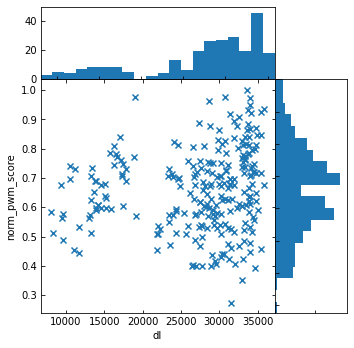

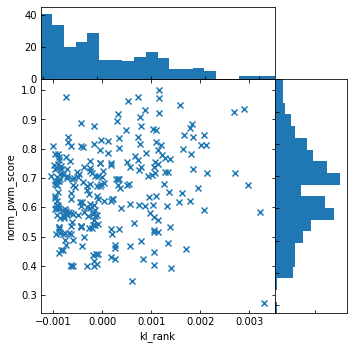

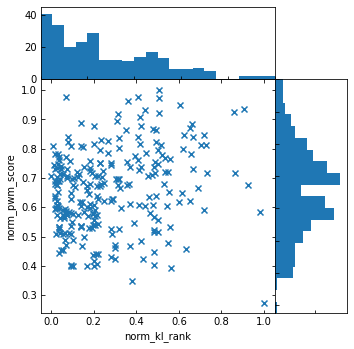

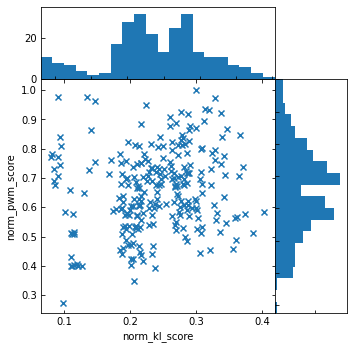

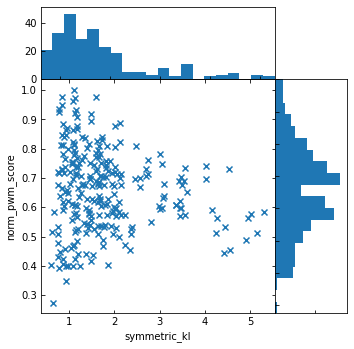

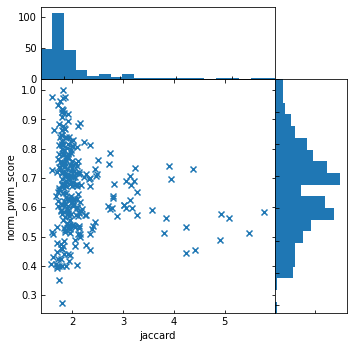

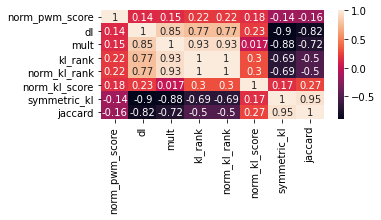

In [22]:
df = exp1_df

plot_2d_scatter(df, 'dl', 'norm_pwm_score')

plot_2d_scatter(df, 'kl_rank', 'norm_pwm_score')
plot_2d_scatter(df, 'norm_kl_rank', 'norm_pwm_score')
plot_2d_scatter(df, 'norm_kl_score', 'norm_pwm_score')
plot_2d_scatter(df, 'symmetric_kl', 'norm_pwm_score')
plot_2d_scatter(df, 'jaccard', 'norm_pwm_score')

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
plt.figure(figsize=(5,2))
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

----

# A comparision on fixed-length word sets using a sequence re-extraction model

In this section we show a comparison between the two scoring procedures $kl\_rank$ and $norm\_kl\_score$ on sets of words of fixed (same) length $k$, by taking into account the nucleotide shuffling model.


In [26]:
epeaks, es2n, egs = read_global_sequence('ENCFF682EOV_allseqs.fa')
edf = pandas.read_csv('ENCFF682EOV_allseqs.nelsa.csv')
print(len(epeaks), len(es2n), len(egs))
e_dnesa = DNESA(list(edf.sa), list(edf.lcp), list(edf.nn), list(edf.dl), egs)

rpeaks, rs2n, rgs = read_global_sequence('ENCFF682EOV_allseqs_random.fa')
rdf = pandas.read_csv('ENCFF682EOV_allseqs_random.nelsa.csv')
print(len(rpeaks), len(rs2n), len(rgs))
r_dnesa = DNESA(list(rdf.sa), list(rdf.lcp), list(rdf.nn), list(rdf.dl), rgs)

39175 39175 18034838
39175 39175 18034838


In [27]:
ctcf = read_jaspar('MA0139.1.jaspar')

In addition a symmetric KL distance and a generalized Jaccard similarity calculated on top of DL vectors are taken into accont.

In [28]:
k = 4

kl_rank, norm_kl_rank =  get_kl_scores(k, egs, e_dnesa, rgs, r_dnesa)
#print(kl_rank)

seq_lengths = dict()
for i in range(len(epeaks)):
    seq_lengths[i] = len(epeaks[i][0])
nof_peaks = len(epeaks)

mult = list()
dl = list()
norm_pwm_score = list()
norm_kl = list()
symmetric_kl = list()
jaccard = list()

for s in kl_rank:
    kmer = s[1]
    
    norm_pwm_score.append( get_normalized_motif_score(ctcf, kmer)[0] )
    norm_kl.append( calculate_norm_kl(kmer, egs, e_dnesa, rgs, r_dnesa, seq_lengths, nof_peaks ) )
    ks, ke = e_dnesa.search(kmer)
    if ks:
        rs, rf = r_dnesa.search(kmer)
        if rs:
            d1 = get_m_distr( e_dnesa, ks, ke )
            d2 = get_m_distr( r_dnesa, rs, rf )
            jaccard.append(calulcate_generalized_jaccard(d1,d2))
            
            d1 = make_prob_distr( add_unzeros( m_dsitr_to_seq_freq( get_m_distr( e_dnesa, ks, ke ), seq_lengths, len(kmer) ), nof_peaks) )
            d2 = make_prob_distr( add_unzeros( m_dsitr_to_seq_freq( get_m_distr( r_dnesa, rs, rf ), seq_lengths, len(kmer) ), nof_peaks) )
            symmetric_kl.append( calculate_symmetric_kl(d1,d2) )
        else:
            symmetric_kl.append(0)
            jaccard.append(0)
        
        mult.append(ke-ks)
        dl.append( len(set(edf.dl[ks:ke])))
    else:
        mult.append(0)
        dl.append(0)
        symmetric_kl.append(0)
        jaccard.append(0)
        
import pandas
exp1_df = pandas.DataFrame()
exp1_df['kmer'] = [ s[1] for s in kl_rank ]
exp1_df['norm_pwm_score'] = norm_pwm_score
exp1_df['dl'] = dl
exp1_df['mult'] = mult
exp1_df['kl_rank'] = [ s[0] for s in kl_rank ]
exp1_df['norm_kl_rank'] = [ s[0] for s in norm_kl_rank ]
exp1_df['norm_kl_score'] = norm_kl
exp1_df['symmetric_kl'] = symmetric_kl
exp1_df['jaccard'] = jaccard

print('-'*40)
display(exp1_df)

exp1_df.to_csv('scores.re-extract.k'+str(k)+'.csv')

----------------------------------------


,kmer,norm_pwm_score,dl,mult,kl_rank,norm_kl_rank,norm_kl_score,symmetric_kl,jaccard
0,GCGC,0.839328,17130,55694,0.004925,1.000000,0.688473,7.644573,14.477847
1,GCCC,0.728067,30840,107766,0.004483,0.951392,0.679722,3.857341,4.138077
2,CCCC,0.754286,28589,114175,0.004439,0.946536,0.634701,4.512163,4.750638
3,CCGC,0.771765,16631,56369,0.004428,0.945354,0.686023,7.631634,13.141234
4,GCGG,0.780504,16505,56366,0.004400,0.942198,0.692899,7.735621,13.392784
...,...,...,...,...,...,...,...,...,...
251,ATAT,0.513613,24308,63497,-0.002219,0.213811,0.328371,3.748660,3.857682
252,AAAT,0.514286,31905,121293,-0.002404,0.193459,0.308307,2.045162,2.623918
253,ATTT,0.404706,32072,121452,-0.002484,0.184653,0.311732,2.038382,2.613947
254,AAAA,0.585546,31449,182061,-0.003997,0.018123,0.341475,2.661713,3.360709


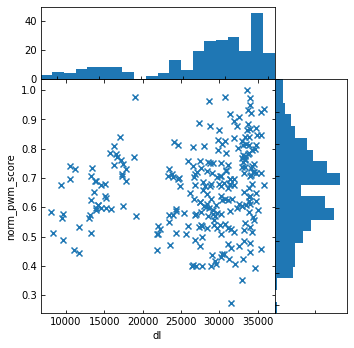

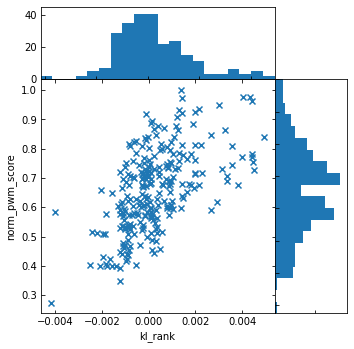

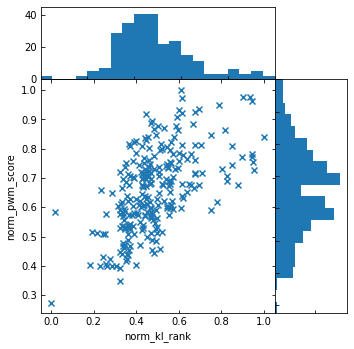

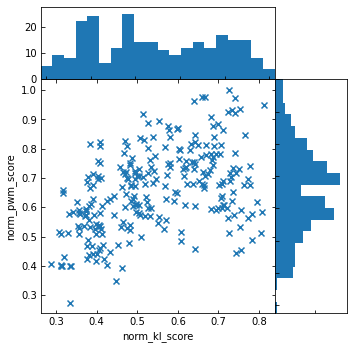

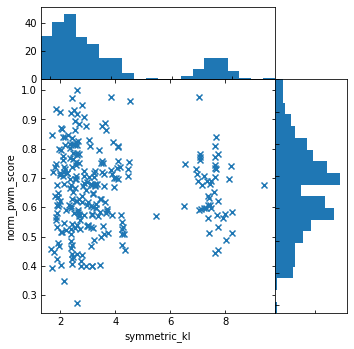

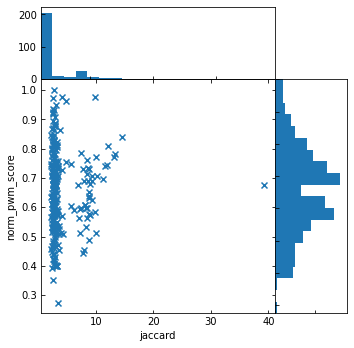

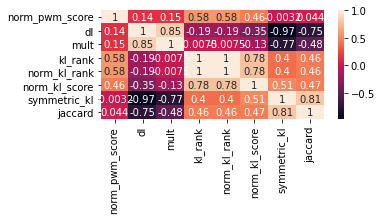

In [29]:
df = exp1_df

plot_2d_scatter(df, 'dl', 'norm_pwm_score')

plot_2d_scatter(df, 'kl_rank', 'norm_pwm_score')
plot_2d_scatter(df, 'norm_kl_rank', 'norm_pwm_score')
plot_2d_scatter(df, 'norm_kl_score', 'norm_pwm_score')
plot_2d_scatter(df, 'symmetric_kl', 'norm_pwm_score')
plot_2d_scatter(df, 'jaccard', 'norm_pwm_score')

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
plt.figure(figsize=(5,2))
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

----

# A simple procedure to extract maximal words given a DL threshold

A simple procedure to extract word as long as possible such that they are present in a certain percentage of sequences is given in what follows.<br>
The aim of the procedure is to extend a given word $w$ ultil the support threshold is satisfied.<br>
Thus, given a threshold $t$, which represent a minimum number of sequences where words must occurr, and a word $w$ such that $dl(w,S)\geq t$,  $w$ is considered maximal if there not exist an elongation of $w$, $wx : x \in \{A,C,G,T\}$, such that $dl(wx,S)\geq t$.<br>
Maximal words are extracted by the algorithm. In contrast, words that satisfy the threshold but that are not maximal, are discarded and their elogations are taken into account.<br>
The procedure is a recursive algoritm which starts form 1-mers and elongate them until maximal words are reached. If 1-mers are considered as roots of a prefix tree, it can be shown that this bottom-up procedure extracts the same words of a top-down procedure which, in constrats, works by aggregating *unfrequent* words.


In [30]:
def get_intervals(istart, iend, k, dnesa):
    """
    Given a word length k, a DNESA, and an initial lcp-interval with coordinates istar-iend which represent a k-mer w, 
    the procedures searches the lcp-interval of the 4 elongations wA, wC, wG and wT.
    The procedure is inefficient since it can be done by a dicotomic seach rather than a linear scan.
    """
    intervals = list()
    
    rstart = istart
    while (rstart < iend) and (dnesa.nn[rstart] <= k) :
        rstart += 1
    
    while rstart < iend:
        rend = rstart + 1
        c = dnesa.gs[ dnesa.sa[rstart] +k ]
        while (rend < iend) and (dnesa.nn[ rend ] >=k ) and ( dnesa.gs[ dnesa.sa[rend] +k ] == c ):
            rend += 1
        intervals.append( (c, rstart, rend) )
        rstart = rend
    return intervals


#good_words = list()
def up_until_dl_thr(w, istart, iend, k, cdl, dl_thr, dnesa, good_words):
    """
    A recursive procedure to extend a word w into an extension wX until dl(wX,S) >= dl_thr, the input support threshold.
    Found maximal words are added up to the list good_words
    """
    intervals = get_intervals(istart, iend, k+1, dnesa)
    #print(intervals)

    good_intervals = list()
    for interval in intervals:
        idl = len(set( dnesa.dl[interval[1]: interval[2]] ))
        if idl >= dl_thr:
            good_intervals.append((interval, idl))

    #print(good_intervals)

    if len(good_intervals)>0:
        for interval in good_intervals:
            up_until_dl_thr(  w+interval[0][0], interval[0][1], interval[0][2], k+1, interval[1], dl_thr, dnesa, good_words )
    else:
        #print(w, cdl)
        good_words.append( (w,istart,iend) )



The support threshold is named *dl_thr_perc* and it is defined as a percentage of the input set $S$.

In [31]:
import math

def extract_maximal_dl_words(iseqs, inelsa, dl_thr_perc):
    # we firstly read the input set S and the DNESA data structure
    epeaks, es2n, egs = read_global_sequence(iseqs)
    edf = pandas.read_csv(inelsa)
    print(len(epeaks), len(es2n), len(egs))
    e_dnesa = DNESA(list(edf.sa), list(edf.lcp), list(edf.nn), list(edf.dl), egs)


    total_dl = len(set(e_dnesa.dl))
    print('total peaks',total_dl)

    #dl_thr_perc = 0.6  #<---- this is the threshold parameter
    dl_thr = math.ceil( total_dl*dl_thr_perc )
    print('thr',dl_thr_perc, '=', dl_thr)


    istart = 0
    iend = len(e_dnesa.gs)

    print('getting 0 intervals')
    intervals = get_intervals(istart, iend, 0, e_dnesa)
    print(intervals)

    good_words = list() 
    for interval in intervals:
        print(interval)
        up_until_dl_thr( interval[0], interval[1], interval[2], 0,  len(set(e_dnesa.dl[interval[1]:interval[2]])), dl_thr, e_dnesa, good_words  )
        
    return good_words


good_words = extract_maximal_dl_words('ENCFF682EOV_allseqs.fa', 'ENCFF682EOV_allseqs.nelsa.csv', 0.8)
print(len(good_words),'extracted words')

39175 39175 18034838
total peaks 39175
thr 0.8 = 31340
getting 0 intervals
[('A', 39177, 4618518), ('C', 4618518, 9031196), ('G', 9031196, 13450633), ('T', 13450633, 18034838)]
('A', 39177, 4618518)
('C', 4618518, 9031196)
('G', 9031196, 13450633)
('T', 13450633, 18034838)
108 extracted words


In [38]:
print(sorted([ s[0] for s in good_words]))
print(len(good_words))

['AAAA', 'AAAG', 'AAAT', 'AACA', 'AAGA', 'AAGC', 'AAGG', 'AAT', 'ACAG', 'ACCA', 'ACCT', 'ACTG', 'AGAA', 'AGAG', 'AGCA', 'AGCC', 'AGCT', 'AGGA', 'AGGC', 'AGGG', 'AGGT', 'AGTG', 'ATA', 'ATC', 'ATG', 'ATTT', 'CAAA', 'CAAG', 'CACA', 'CACC', 'CACT', 'CAGA', 'CAGC', 'CAGG', 'CAGT', 'CAT', 'CCAA', 'CCAC', 'CCAG', 'CCCA', 'CCCT', 'CCTC', 'CCTG', 'CCTT', 'CG', 'CTA', 'CTCA', 'CTCC', 'CTCT', 'CTGA', 'CTGC', 'CTGG', 'CTGT', 'CTTC', 'CTTG', 'CTTT', 'GAAA', 'GAAG', 'GAC', 'GAGA', 'GAGG', 'GAT', 'GCAG', 'GCCA', 'GCCT', 'GCTC', 'GCTG', 'GCTT', 'GGAA', 'GGAG', 'GGCA', 'GGCT', 'GGGA', 'GGTG', 'GTA', 'GTC', 'GTGG', 'GTT', 'TAA', 'TAC', 'TAG', 'TAT', 'TCAG', 'TCCA', 'TCCC', 'TCCT', 'TCTC', 'TCTG', 'TCTT', 'TGAA', 'TGAG', 'TGCA', 'TGCC', 'TGCT', 'TGGA', 'TGGC', 'TGGG', 'TGGT', 'TGTG', 'TGTT', 'TTA', 'TTCA', 'TTCC', 'TTCT', 'TTGG', 'TTTC', 'TTTG', 'TTTT']
108


---- 

# A comparison on variable-length words, with the sequence re-extraction model

In [39]:
epeaks, es2n, egs = read_global_sequence('ENCFF682EOV_allseqs.fa')
edf = pandas.read_csv('ENCFF682EOV_allseqs.nelsa.csv')
print(len(epeaks), len(es2n), len(egs))
e_dnesa = DNESA(list(edf.sa), list(edf.lcp), list(edf.nn), list(edf.dl), egs)

rpeaks, rs2n, rgs = read_global_sequence('ENCFF682EOV_allseqs_random.fa')
rdf = pandas.read_csv('ENCFF682EOV_allseqs_random.nelsa.csv')
print(len(rpeaks), len(rs2n), len(rgs))
r_dnesa = DNESA(list(rdf.sa), list(rdf.lcp), list(rdf.nn), list(rdf.dl), rgs)

ctcf = read_jaspar('MA0139.1.jaspar')

39175 39175 18034838
39175 39175 18034838


We first need to calculate $kl\_rank$ for words in a range of lengths.

In [40]:
d_kl_rank = dict()
d_norm_kl_rank = dict()

for k in range(2,7):
    print(k)
    k_kl_rank, k_norm_kl_rank =  get_kl_scores(k, egs, e_dnesa, rgs, r_dnesa)
    for s in k_kl_rank:
        d_kl_rank[ s[1] ] = s[0]
    for s in k_norm_kl_rank:
        d_norm_kl_rank[ s[1] ] = s[0]


2
3
4
5
6


Now we extract the words by usgin the simple procedure based on DL threshold

In [41]:
dl_thr = 0.8
extracted_words = extract_maximal_dl_words('ENCFF682EOV_allseqs.fa', 'ENCFF682EOV_allseqs.nelsa.csv', dl_thr)
print(len(good_words),'extracted words')

39175 39175 18034838
total peaks 39175
thr 0.8 = 31340
getting 0 intervals
[('A', 39177, 4618518), ('C', 4618518, 9031196), ('G', 9031196, 13450633), ('T', 13450633, 18034838)]
('A', 39177, 4618518)
('C', 4618518, 9031196)
('G', 9031196, 13450633)
('T', 13450633, 18034838)
108 extracted words


In [42]:
seq_lengths = dict()
for i in range(len(epeaks)):
    seq_lengths[i] = len(epeaks[i][0])
nof_peaks = len(epeaks)

kl_rank = list()
norm_kl_rank = list()
mult = list()
dl = list()
norm_pwm_score = list()
norm_kl = list()
symmetric_kl = list()
jaccard = list()

for kmer in extracted_words:
    kmer = kmer[0]
    norm_pwm_score.append( get_normalized_motif_score(ctcf, kmer)[0] )
    
    kl_rank.append( d_kl_rank.get(kmer, 0) )
    norm_kl_rank.append( d_norm_kl_rank.get(kmer, 0) )
    
    norm_kl.append( calculate_norm_kl(kmer, egs, e_dnesa, rgs, r_dnesa, seq_lengths, nof_peaks ) )
    
    ks, ke = e_dnesa.search(kmer)
    if ks:
        rs, rf = r_dnesa.search(kmer)
        if rs:
            d1 = get_m_distr( e_dnesa, ks, ke )
            d2 = get_m_distr( r_dnesa, rs, rf )
            jaccard.append(calulcate_generalized_jaccard(d1,d2))
            
            d1 = make_prob_distr( add_unzeros( m_dsitr_to_seq_freq( get_m_distr( e_dnesa, ks, ke ), seq_lengths, len(kmer) ), nof_peaks) )
            d2 = make_prob_distr( add_unzeros( m_dsitr_to_seq_freq( get_m_distr( r_dnesa, rs, rf ), seq_lengths, len(kmer) ), nof_peaks) )
            symmetric_kl.append( calculate_symmetric_kl(d1,d2) )
        else:
            symmetric_kl.append(0)
            jaccard.append(0)
        
        mult.append(ke-ks)
        dl.append( len(set(edf.dl[ks:ke])))
    else:
        mult.append(0)
        dl.append(0)
        symmetric_kl.append(0)
        jaccard.append(0)
        
import pandas
exp1_df = pandas.DataFrame()
exp1_df['kmer'] = [kmer[0] for kmer in extracted_words]
exp1_df['norm_pwm_score'] = norm_pwm_score
exp1_df['dl'] = dl
exp1_df['mult'] = mult
exp1_df['kl_rank'] = kl_rank
exp1_df['norm_kl_rank'] = norm_kl_rank
exp1_df['norm_kl_score'] = norm_kl
exp1_df['symmetric_kl'] = symmetric_kl
exp1_df['jaccard'] = jaccard

print('-'*40)
display(exp1_df)

exp1_df.to_csv('scores.re-extract.simple-maximal.'+str(dl_thr)+'.csv')

----------------------------------------


,kmer,norm_pwm_score,dl,mult,kl_rank,norm_kl_rank,norm_kl_score,symmetric_kl,jaccard
0,AAAA,0.585546,31449,182061,-0.003997,0.018123,0.341475,2.661713,3.360709
1,AAAG,0.638992,34048,108751,-0.000914,0.357403,0.443563,1.806625,2.383164
2,AAAT,0.514286,31905,121293,-0.002404,0.193459,0.308307,2.045162,2.623918
3,AACA,0.695126,31458,85195,-0.001097,0.337321,0.402022,2.354883,2.623570
4,AAGA,0.737479,32974,97681,-0.000989,0.349181,0.458306,2.143137,2.549798
...,...,...,...,...,...,...,...,...,...
103,TTCT,0.391261,34660,116181,-0.001208,0.325128,0.462575,1.706579,2.358657
104,TTGG,0.677311,31968,75623,-0.000291,0.426012,0.484835,2.376434,2.446229
105,TTTC,0.531092,33961,112946,-0.001012,0.346671,0.460108,1.876371,2.409775
106,TTTG,0.422185,33130,100202,-0.001662,0.275162,0.375018,1.897285,2.505656


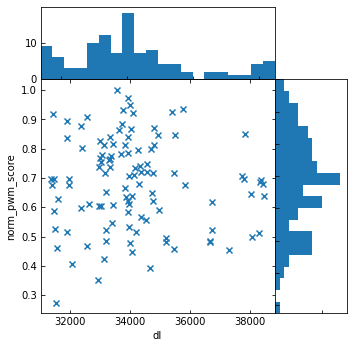

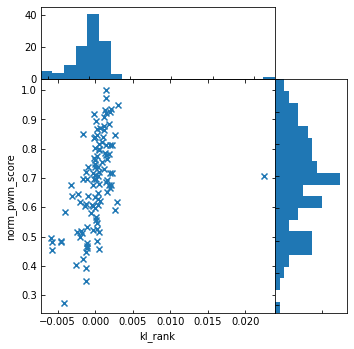

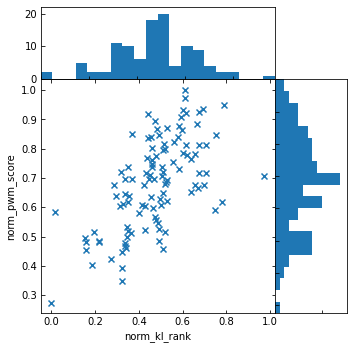

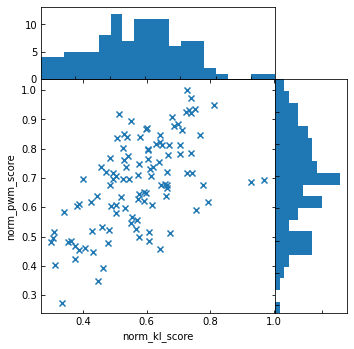

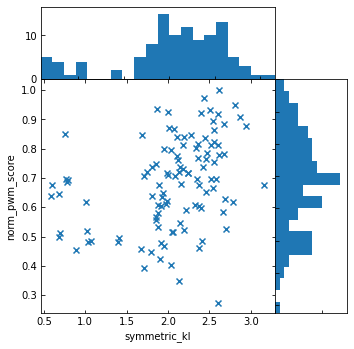

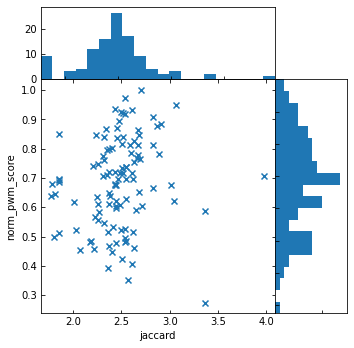

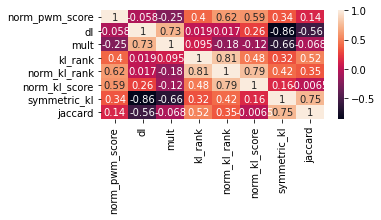

In [43]:
df = exp1_df

plot_2d_scatter(df, 'dl', 'norm_pwm_score')

plot_2d_scatter(df, 'kl_rank', 'norm_pwm_score')
plot_2d_scatter(df, 'norm_kl_rank', 'norm_pwm_score')
plot_2d_scatter(df, 'norm_kl_score', 'norm_pwm_score')
plot_2d_scatter(df, 'symmetric_kl', 'norm_pwm_score')
plot_2d_scatter(df, 'jaccard', 'norm_pwm_score')

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
plt.figure(figsize=(5,2))
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()